# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct as fcountDistinct
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import count as fcount
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import datetime

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
print((df.count(), len(df.columns)))

(286500, 18)


Now that I understand the datase a little better, let's do take the following steps in cleaning the data:
* check for user ID and session ID
* drop rows with missing values or empty strings for user ID and session ID
* format timestamp

In [7]:
df.filter(df['userId'].isNull()).count()

0

In [8]:
df.filter(df['sessionId'].isNull()).count()

0

In [9]:
df.filter(df['userId']=='').count()

8346

In [10]:
df.filter(df['sessionId']=='').count()

0

In [11]:
# cleaning out based on User ID and Session ID
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])
df = df.filter(df['userId']!='')

In [12]:
print((df.count(), len(df.columns)))

(278154, 18)


In [13]:
time_stamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("formatted_timestamp", time_stamp(df.ts))

In [14]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', formatted_timestamp='2018-10-01 00:01:57')

The number of rows has dropped from eliminating the empty User IDs and now there's a clean formatted timestamp.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

My prefered method for querying the data will be SQL, so I'll start by creating a view.

In [15]:
df.createOrReplaceTempView("logs")

spark.sql('''
              SELECT userID, artist, gender, formatted_timestamp, location, level, method, page
              FROM logs
              limit 5
          '''
          ).show()

+------+----------------+------+-------------------+--------------------+-----+------+--------+
|userID|          artist|gender|formatted_timestamp|            location|level|method|    page|
+------+----------------+------+-------------------+--------------------+-----+------+--------+
|    30|  Martha Tilston|     M|2018-10-01 00:01:57|     Bakersfield, CA| paid|   PUT|NextSong|
|     9|Five Iron Frenzy|     M|2018-10-01 00:03:00|Boston-Cambridge-...| free|   PUT|NextSong|
|    30|    Adam Lambert|     M|2018-10-01 00:06:34|     Bakersfield, CA| paid|   PUT|NextSong|
|     9|          Enigma|     M|2018-10-01 00:06:56|Boston-Cambridge-...| free|   PUT|NextSong|
|    30|       Daft Punk|     M|2018-10-01 00:11:16|     Bakersfield, CA| paid|   PUT|NextSong|
+------+----------------+------+-------------------+--------------------+-----+------+--------+



Churn is going to be defined as users who cancel their account and go through the event "Cancellation Confirmation".

In [16]:
spark.sql('''
              SELECT count(distinct userID)
              FROM logs
              where page = 'Cancellation Confirmation'
          '''
          ).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                    52|
+----------------------+



In [17]:
spark.sql('''
              SELECT count(distinct userID)
              FROM logs
          '''
          ).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   225|
+----------------------+



In the logs, there are 52 out of 225 users who churned. Let's split them into two user groups to analyze their behaviors.

In [18]:
churned_users = spark.sql('''
              SELECT distinct userID
              FROM logs
              where page = 'Cancellation Confirmation'
          '''
          )

In [19]:
churned_users.show()

+------+
|userID|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
+------+
only showing top 20 rows



In [20]:
retained_users = spark.sql(''' select userID
                                from logs
                                group by userID
                                having count(case when page = 'Cancellation Confirmation' then userID else null end) = 0
                            '''
                           )

In [21]:
retained_users.show()

+------+
|userID|
+------+
|100010|
|200002|
|   124|
|     7|
|    15|
|   155|
|   132|
|   154|
|    11|
|   138|
|300017|
|    69|
|    42|
|   112|
|    64|
|200010|
|    30|
|   113|
|    34|
|   133|
+------+
only showing top 20 rows



In [22]:
churned_user_ids = churned_users.select("userID").rdd.flatMap(lambda x: x).collect()
retained_user_ids = retained_users.select("userID").rdd.flatMap(lambda x: x).collect()

In [23]:
df_churned = df.filter(df.userId.isin(churned_user_ids))
df_churned.createOrReplaceTempView("churned_logs")
df_retained = df.filter(df.userId.isin(retained_user_ids))
df_retained.createOrReplaceTempView("retained_logs")

Confirming number of users:

In [24]:
spark.sql('''select count(distinct userId) from churned_logs''').show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    52|
+----------------------+



In [25]:
spark.sql('''select count(distinct userId) from retained_logs''').show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   173|
+----------------------+



Gender distribution:

In [26]:
spark.sql('''select gender, count(distinct userId) / 52 as percentage_gender
            from churned_logs
            group by gender
            ''').show()

+------+-------------------+
|gender|  percentage_gender|
+------+-------------------+
|     F|0.38461538461538464|
|     M| 0.6153846153846154|
+------+-------------------+



In [27]:
spark.sql('''select gender, count(distinct userId) / 173 as percentage_gender
            from retained_logs
            group by gender
            ''').show()

+------+-------------------+
|gender|  percentage_gender|
+------+-------------------+
|     F|0.48554913294797686|
|     M| 0.5144508670520231|
+------+-------------------+



Free vs Paid distribution:

In [28]:
spark.sql('''select level, count(distinct userId) / 52 as percentage_level
            from churned_logs
            group by level
            ''').show()

+-----+------------------+
|level|  percentage_level|
+-----+------------------+
| free|0.8846153846153846|
| paid|0.6923076923076923|
+-----+------------------+



In [29]:
spark.sql('''select level, count(distinct userId) / 173 as percentage_level
            from retained_logs
            group by level
            ''').show()

+-----+------------------+
|level|  percentage_level|
+-----+------------------+
| free| 0.861271676300578|
| paid|0.7456647398843931|
+-----+------------------+



Location Distribution:

In [30]:
states_churned = spark.sql('''select right(location, 2) as state, count(distinct userId) / 52 as percentage_state
            from churned_logs
            group by right(location, 2)
            order by percentage_state desc
            limit 10
            ''')
states_churned.show()

+-----+--------------------+
|state|    percentage_state|
+-----+--------------------+
|   CA| 0.11538461538461539|
|   PA| 0.09615384615384616|
|   MD|0.057692307692307696|
|   MI|0.057692307692307696|
|   TX|0.057692307692307696|
|   FL|0.057692307692307696|
|   AL|0.038461538461538464|
|   WA|0.038461538461538464|
|   CO|0.038461538461538464|
|   OH|0.038461538461538464|
+-----+--------------------+



In [31]:
states_churned.toPandas().plot.bar(x='state', y='percentage_state')

In [32]:
states_retained = spark.sql('''select right(location, 2) as state, count(distinct userId) / 173 as percentage_state
            from retained_logs
            group by right(location, 2)
            order by percentage_state desc
            limit 10
            ''')
states_retained.show()

+-----+--------------------+
|state|    percentage_state|
+-----+--------------------+
|   CA| 0.15606936416184972|
|   PA| 0.07514450867052024|
|   TX| 0.07514450867052024|
|   FL| 0.06358381502890173|
|   WI| 0.05202312138728324|
|   IL|0.046242774566473986|
|   NC| 0.04046242774566474|
|   NH| 0.04046242774566474|
|   SC| 0.04046242774566474|
|   CT| 0.04046242774566474|
+-----+--------------------+



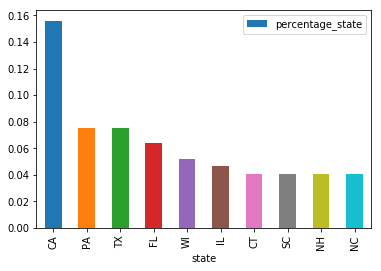

In [33]:
states_retained.toPandas().plot.bar(x='state', y='percentage_state')

Observations from EDA:
* Gender distribution is different from churned to retained users
* Free vs Paid seems to have a small difference
* State distribution also seems to be relevant

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
sql_query_start = '''
        with basics as (
            select distinct userID, gender, right(location, 2) as state, 1 as churn
            from churned_logs
            union all
            select distinct userID, gender, right(location, 2) as state, 0 as churn
            from retained_logs
        )
        
        select case when gender = 'M' then 1 else 0 end as gender_M,
            case when gender = 'F' then 1 else 0 end as gender_F,
        
    '''
all_states = spark.sql('''select distinct right(location, 2) as state from logs''')
    
columns = ['gender_M', 'gender_F']
for state in all_states.select('state').collect():
    sql_query_start += '''case when state = '{st}' then 1 else 0 end as is_{st},\n'''.format(st = state.state)
    columns.append("is_" + state.state)
sql_query = sql_query_start + 'churn\nfrom basics'

dataset = spark.sql(sql_query)

In [35]:
dataset.show()

+--------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|gender_M|gender_F|is_AZ|is_SC|is_LA|is_NJ|is_OR|is_VA|is_KY|is_NH|is_MI|is_NV|is_WI|is_ID|is_CA|is_CT|is_MT|is_NC|is_MD|is_MO|is_IL|is_WA|is_MS|is_AL|is_IN|is_OH|is_TN|is_IA|is_PA|is_NY|is_TX|is_WV|is_GA|is_MA|is_KS|is_FL|is_CO|is_AK|is_AR|is_OK|is_UT|churn|
+--------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|       1|       0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|    0|   

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Steps I'll take:
 - Vectorization
 - Standardization
 - Split


In [36]:
assembler = VectorAssembler(inputCols = columns, outputCol='vector')
int_df = assembler.transform(dataset)


scaler = StandardScaler(inputCol="vector", outputCol="features", withStd=True).fit(int_df)
ready_df = scaler.transform(int_df)

train, test, validation = ready_df.randomSplit([0.6, 0.2, 0.2], seed = 42)

I'll try the following models:
* Logistic Regression --> basic classifier
* Random Forest --> known for good performance in classification

In [37]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churn')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'churn')

evaluator = MulticlassClassificationEvaluator(labelCol = 'churn')

In [38]:
for model in [lr, rf]:
    model = model.fit(train)
    predictions = model.transform(validation)
    print("for model {m}, F1 on validation set was {f1}".format(
                            m = model.__class__.__name__, 
                            f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

for model LogisticRegressionModel, F1 on validation set was 0.7139165743816908
for model RandomForestClassificationModel, F1 on validation set was 0.6350387596899224


# Future steps to advance this work
Although the F1 was relatively good for the Logistic Regression Model, there are other steps that we can take to try to advance this result further:
* Consider other variables like:
  * days since sign up
  * whether was free or paid right before churn
* Try other models like Naive Bayes, Neural Nets and GBT
* Use pipeline and grid search to combine sequential models and search the best parameters

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.